# Analysis

Let's look at one particular example of the CORD dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


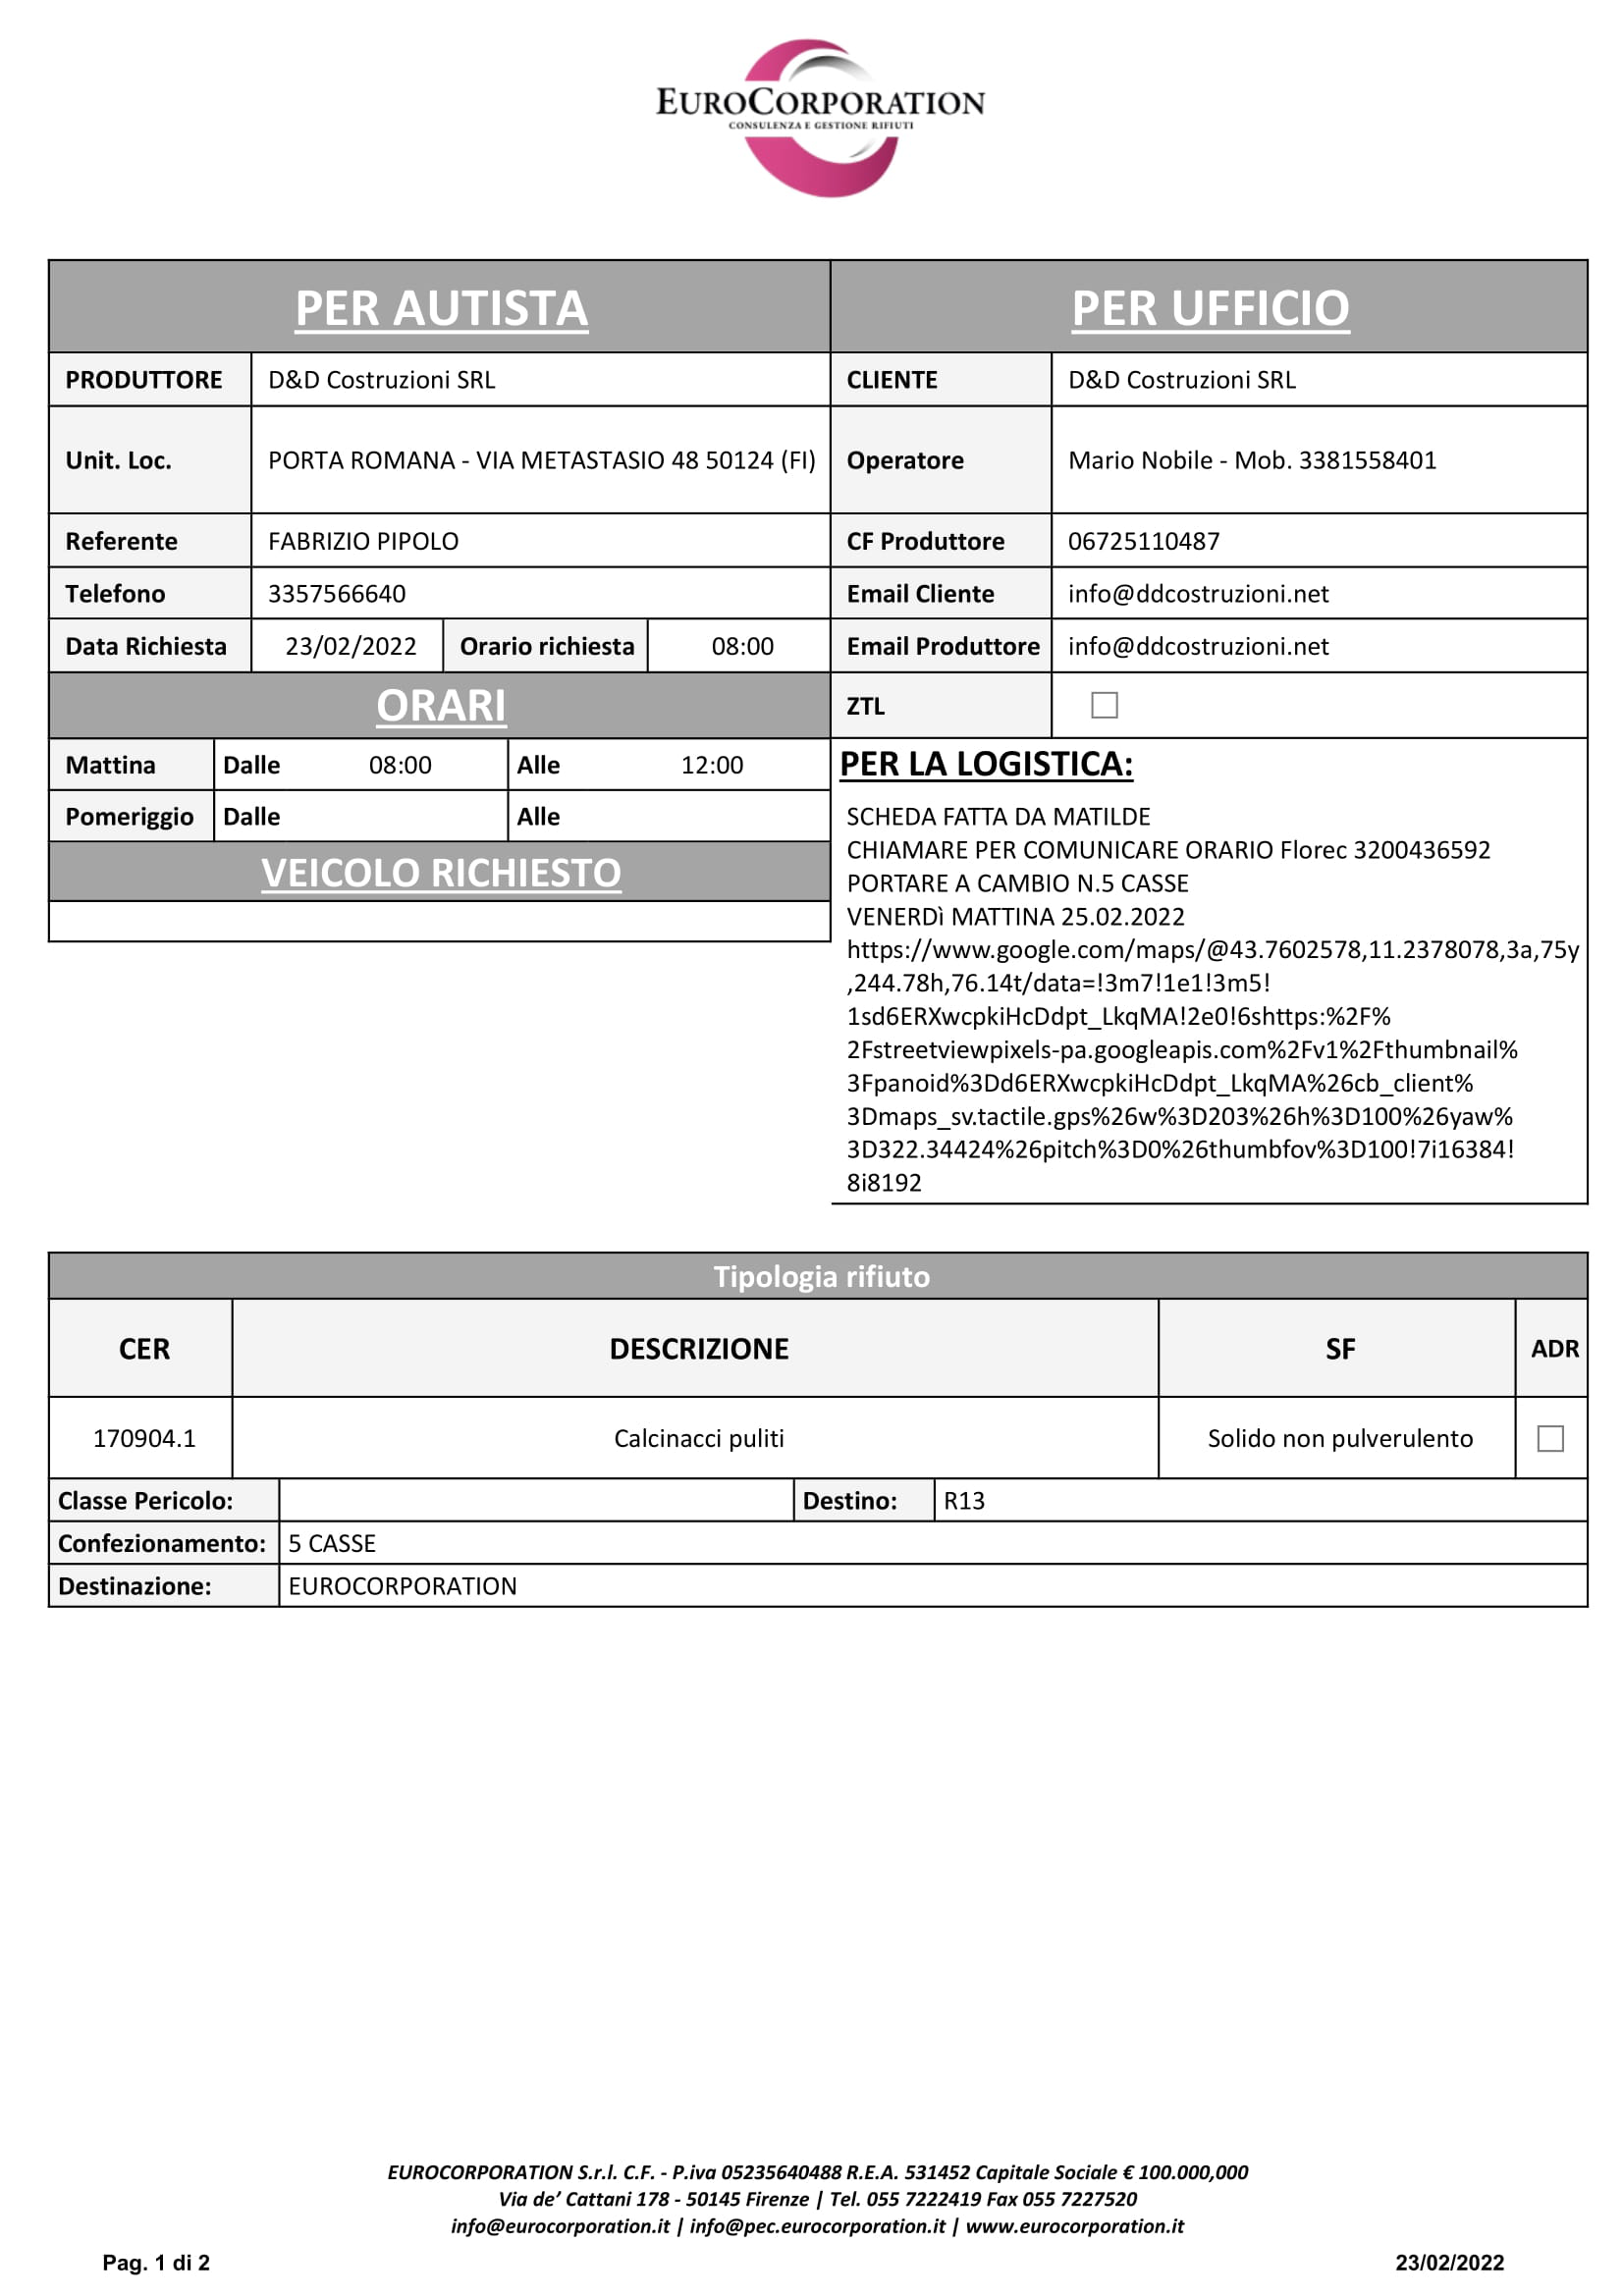

In [2]:
from PIL import Image

image = Image.open('/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/CORD dataset/layoutLMV2 -CORD/images/train/1.jpg')
image

Let's read in the corresponding OCR annotations.

In [3]:
import json

with open('/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/CORD dataset/layoutLMV2 -CORD/JSON/train/1.json') as json_file:
    data = json.load(json_file)

In [4]:
data.keys()

dict_keys(['dontcare', 'valid_line', 'meta', 'roi', 'repeating_symbol'])

In [5]:
data['meta']

{'image_id': 1,
 'image_size': {'height': 2339, 'width': 1653},
 'split': 'train',
 'version': 'v0.1'}

In [6]:
data['roi']

{}

In [7]:
data['repeating_symbol']

[]

This particular example has 93 OCR annotations:

In [8]:
len(data['valid_line'])

6

Let's look at the first one:

In [9]:
cat_list = []
for i in range(len(data['valid_line'])):
  cat_list.append(data['valid_line'][i].get('category'))
cat_list 

['produttore', 'unitloc', 'datarichiesta', 'orariorichiesta', 'cer', 'others']

Let's annotate the image with the corresponding bounding boxes:

In [10]:
import random

labels = cat_list
# ['menu.cnt',
#  'menu.discountprice',
#  'menu.etc',
#  'menu.itemsubtotal',
#  'menu.nm',
#  'menu.num',
#  'menu.price',
#  'menu.sub_cnt',
#  'menu.sub_etc',
#  'menu.sub_nm',
#  'menu.sub_price',
#  'menu.sub_unitprice',
#  'menu.unitprice',
#  'menu.vatyn',
#  'sub_total.discount_price',
#  'sub_total.etc',
#  'sub_total.othersvc_price',
#  'sub_total.service_price',
#  'sub_total.subtotal_price',
#  'sub_total.tax_price',
#  'total.cashprice',
#  'total.changeprice',
#  'total.creditcardprice',
#  'total.emoneyprice',
#  'total.menuqty_cnt',
#  'total.menutype_cnt',
#  'total.total_etc',
#  'total.total_price',
#  'void_menu.nm',
#  'void_menu.price']

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
print(colors)

['#01d1d9', '#82e329', '#4b9599', '#886b49', '#658014', '#c6f200']


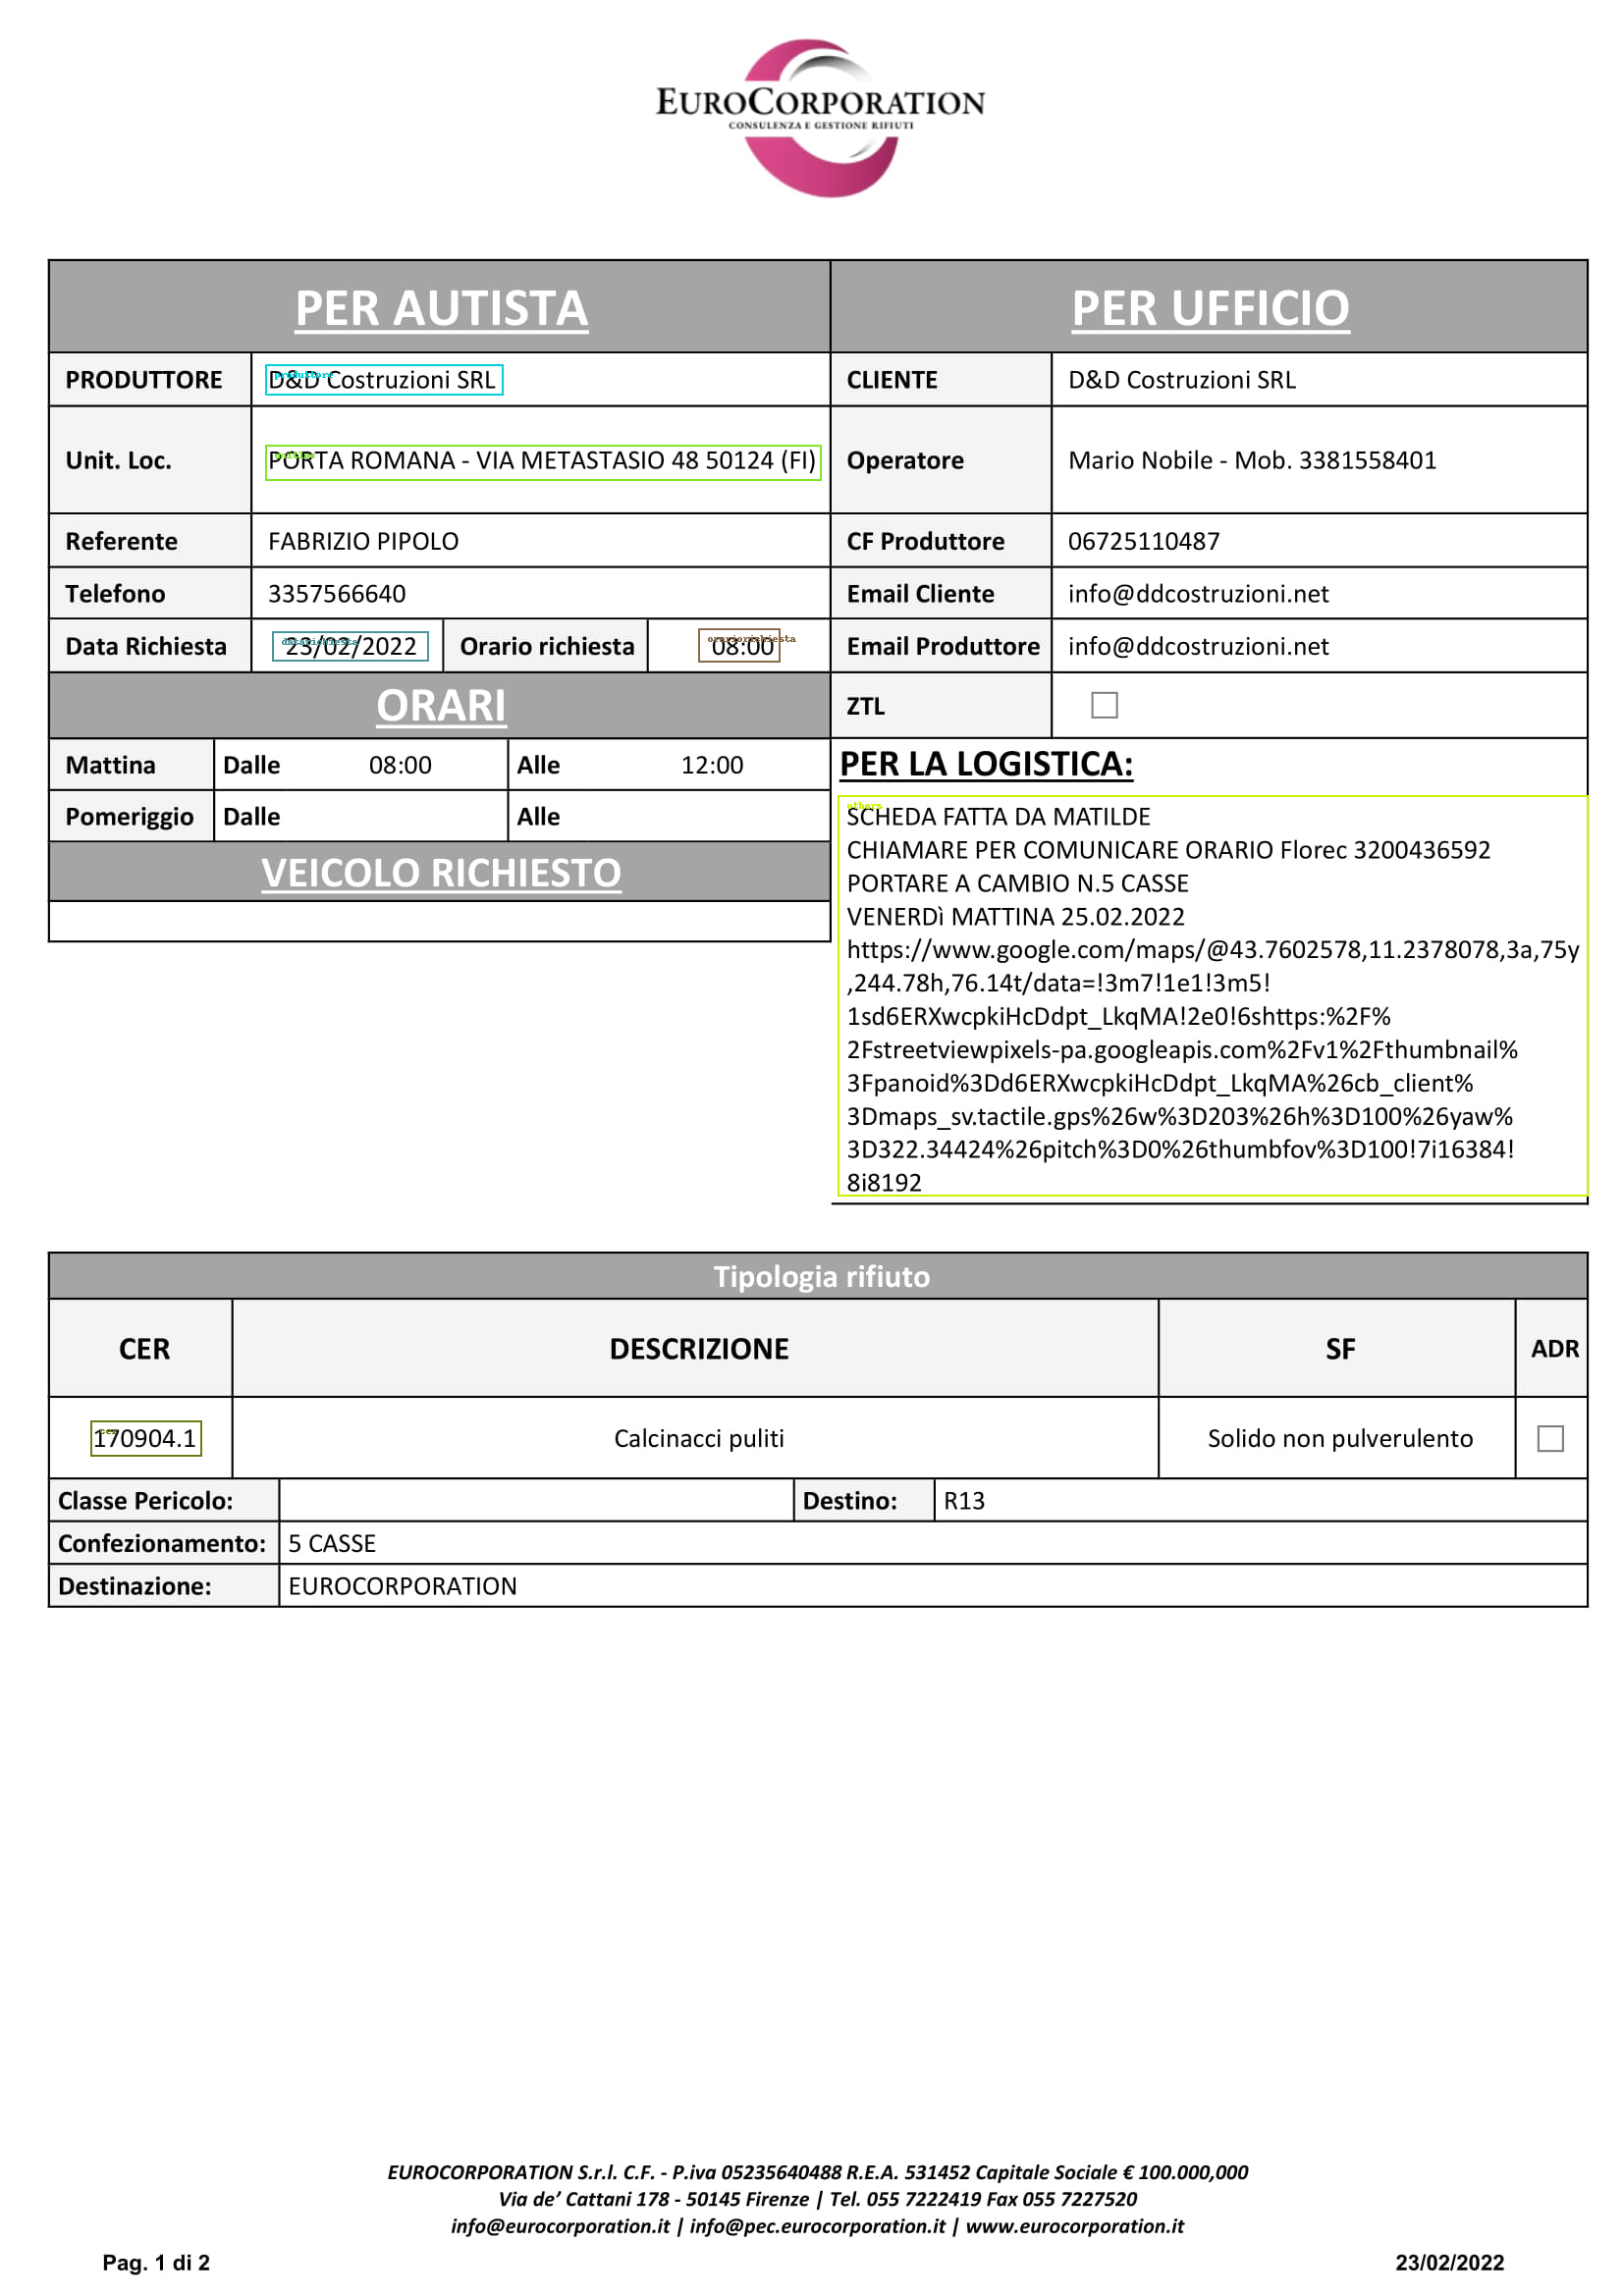

In [11]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

for annotation in data['valid_line']:
  label = annotation['category']
  words = annotation['words']
  for word in words:
    coordinates = word['quad']
    x1, y1 = coordinates['x1'], coordinates['y1']
    x3, y3 = coordinates['x3'], coordinates['y3']
    box = [x3, y1, x1, y3]
    draw.rectangle(box, outline=label2color[label], width=2)
    draw.text((box[0]+10, box[1]+5), label, fill=label2color[label], font=font)

image

# Generating the dataset

In [34]:
from tqdm.notebook import tqdm
from pathlib import Path
import os

def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

def generate_annotations(path: str):
  annotation_files = []
  image_files = []
  for js in tqdm(os.listdir(path)):
    image_files.append(Path(js).name.replace('.json', '.jpg'))
    with open(path + js) as f:
        annotation_files.append(json.load(f))
  
  words = []
  boxes = []
  labels = []
  images = []
  for js, im in tqdm(zip(annotation_files, image_files)):
      words_example = []
      boxes_example = []
      labels_example = []

      width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']
      # loop over OCR annotations
      for elem in js['valid_line']:
          for word in elem['words']:
              # get word
              txt = word['text']

              # get bounding box
              # important: each bounding box should be in (upper left, lower right) format
              # it took me some time to understand the upper left is (x1, y3)
              # and the lower right is (x3, y1)
              x1 = word['quad']['x1']
              y1 = word['quad']['y1']
              x3 = word['quad']['x3']
              y3 = word['quad']['y3']
              
              box = [x3, y1, x1, y3]
              box = normalize_bbox(box, width=width, height=height)

              # ADDED
              # skip empty word
              # if len(txt) < 1: 
              #   continue
              # if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
              #   continue
              # if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -12
              #   continue
              # ADDED

              words_example.append(txt)
              boxes_example.append(box) 
              labels_example.append(elem['category'])
      words.append(words_example) 
      boxes.append(boxes_example)
      labels.append(labels_example)
      images.append(im)
  
  return words, boxes, labels, images

Let's apply the function above for the training, validation and test set:

In [35]:
train_path = '/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/CORD dataset/layoutLMV2 -CORD/JSON/train/'
val_path = '/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/CORD dataset/layoutLMV2 -CORD/JSON/val/'
test_path = '/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/CORD dataset/layoutLMV2 -CORD/JSON/test/'

words_train, boxes_train, labels_train, images_train = generate_annotations(train_path)
words_val, boxes_val, labels_val, images_val = generate_annotations(val_path)
words_test, boxes_test, labels_test, images_test = generate_annotations(test_path)

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [36]:
labels_train[0]

['produttore', 'unitloc', 'datarichiesta', 'orariorichiesta', 'cer', 'others']

In [37]:
words_train[0]

['D&D Costruzioni SRL',
 'PORTA ROMANA - VIA METASTASIO 48 50124 (FI)',
 '23/02/2022',
 '08:00',
 '170904.1',
 'SCHEDA FATTA DA MATILDE CHIAMARE PER COMUNICARE ORARIO Florec 3200436592 PORTARE A CAMBIO N.5 CASSE VENERDì MATTINA 25.02.2022https://www.google.com/maps/@43.7602578,11.2378078,3a,75y,244.78h,76.14t/data=!3m7!1e1!3m5! 1sd6ERXwcpkiHcDdpt_LkqMA!2e0!6shttps:%2F%  2Fstreetviewpixels-pa.googleapis.com%2Fv1%2Fthumbnail% 3Fpanoid%3Dd6ERXwcpkiHcDdpt_LkqMA%26cb_client% 3Dmaps_sv.tactile.gps%26w%3D203%26h%3D100%26yaw% 3D322.34424%26pitch%3D0%26thumbfov%3D100!7i16384! 8i8192']

In [38]:
boxes_train[0]

[[163, 158, 309, 171],
 [163, 193, 505, 209],
 [167, 274, 263, 287],
 [430, 273, 480, 288],
 [55, 618, 124, 634],
 [516, 346, 978, 520]]

# Saving

In [39]:
import pickle
with open('/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/CORD dataset/pkl/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train, images_train], t)
with open('/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/CORD dataset/pkl/val.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val, images_val], t)
with open('/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/CORD dataset/pkl/test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test, images_test], t)

In [40]:
import pandas as pd
train_df = pd.read_pickle('/content/drive/Shareddrives/Data Science Team folder-open/Jyoti/CORD dataset/pkl/train.pkl')
train_df

[[['D&D Costruzioni SRL',
   'PORTA ROMANA - VIA METASTASIO 48 50124 (FI)',
   '23/02/2022',
   '08:00',
   '170904.1',
   'SCHEDA FATTA DA MATILDE CHIAMARE PER COMUNICARE ORARIO Florec 3200436592 PORTARE A CAMBIO N.5 CASSE VENERDì MATTINA 25.02.2022https://www.google.com/maps/@43.7602578,11.2378078,3a,75y,244.78h,76.14t/data=!3m7!1e1!3m5! 1sd6ERXwcpkiHcDdpt_LkqMA!2e0!6shttps:%2F%  2Fstreetviewpixels-pa.googleapis.com%2Fv1%2Fthumbnail% 3Fpanoid%3Dd6ERXwcpkiHcDdpt_LkqMA%26cb_client% 3Dmaps_sv.tactile.gps%26w%3D203%26h%3D100%26yaw% 3D322.34424%26pitch%3D0%26thumbfov%3D100!7i16384! 8i8192'],
  ['LUPU CATALIN',
   'LUCCA - Via Borgo Giannotti 505 d (casa privata in ritrutturazione) 55100',
   '15/02/2022',
   '10:00',
   '170904.1',
   "18.02.2022 DOPO LE ORE 10:00 SCHEDA FATTA DA MATILDE CHIAMARE PER CONFERMA IL GIORNO PRIMA CAMBIO 5 CASSE --> IL CLIENTE CHIEDE DELLE CASSE DECENTI PERCHE' QUELLE CHE GLI SONO STATE CONSEGNATE SONO TUTTE SFONSATE E ROTTE MEZZI IN OFFERTA: FURGONE 6PP PER AU